# WIND AND SOLAR FOR ALL EU COUNTRIES, 2015-2020, ENTSO-E
ENTSO-E data for each country containing capacity and generation for wind and solar for each European country (except North Macedonia)

In [110]:
# Importing packages
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import numpy as np

import pgeocode
from collections import OrderedDict
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

#sns.set_style("whitegrid")

import requests
import os
import zipfile

import atlite
import logging
logging.basicConfig(level=logging.INFO)

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from matplotlib.gridspec import GridSpec
from atlite.gis import shape_availability, ExclusionContainer
from rasterio.plot import show

Creating a function that will download data from url and save it.

In [3]:
# Defining function that helps download date from an url that downloads a .csv file
def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return local_filename

Downloading data from ENTSO-E using https://data.open-power-system-data.org/
(Download and then go into downloads in chrome and copy link)

In [4]:
opsd= download_file(
    "https://data.open-power-system-data.org/index.php?package=time_series&version=2020-10-06&action=customDownload&resource=3&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2015-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2020-10-01&filter%5BRegion%5D%5B%5D=AT&filter%5BRegion%5D%5B%5D=BE&filter%5BRegion%5D%5B%5D=BG&filter%5BRegion%5D%5B%5D=CH&filter%5BRegion%5D%5B%5D=CY&filter%5BRegion%5D%5B%5D=CZ&filter%5BRegion%5D%5B%5D=DE&filter%5BRegion%5D%5B%5D=DK&filter%5BRegion%5D%5B%5D=EE&filter%5BRegion%5D%5B%5D=ES&filter%5BRegion%5D%5B%5D=FI&filter%5BRegion%5D%5B%5D=FR&filter%5BRegion%5D%5B%5D=GB_GBN&filter%5BRegion%5D%5B%5D=GB_NIR&filter%5BRegion%5D%5B%5D=GR&filter%5BRegion%5D%5B%5D=HR&filter%5BRegion%5D%5B%5D=HU&filter%5BRegion%5D%5B%5D=IE&filter%5BRegion%5D%5B%5D=IT&filter%5BRegion%5D%5B%5D=LT&filter%5BRegion%5D%5B%5D=LU&filter%5BRegion%5D%5B%5D=LV&filter%5BRegion%5D%5B%5D=ME&filter%5BRegion%5D%5B%5D=NL&filter%5BRegion%5D%5B%5D=NO&filter%5BRegion%5D%5B%5D=PL&filter%5BRegion%5D%5B%5D=PT&filter%5BRegion%5D%5B%5D=RO&filter%5BRegion%5D%5B%5D=RS&filter%5BRegion%5D%5B%5D=SE&filter%5BRegion%5D%5B%5D=SI&filter%5BRegion%5D%5B%5D=SK&filter%5BRegion%5D%5B%5D=UA&filter%5BVariable%5D%5B%5D=load_actual_entsoe_transparency&filter%5BVariable%5D%5B%5D=solar_capacity&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=wind_capacity&filter%5BVariable%5D%5B%5D=wind_generation_actual&filter%5BVariable%5D%5B%5D=wind_offshore_capacity&filter%5BVariable%5D%5B%5D=wind_offshore_generation_actual&filter%5BVariable%5D%5B%5D=wind_onshore_capacity&filter%5BVariable%5D%5B%5D=wind_onshore_generation_actual&downloadCSV=Download+CSV",
    "time_series_EU_wind_solar.csv",
)

Formatting the data better: 

In [5]:
opsd = pd.read_csv(opsd, parse_dates=True,header=0, index_col=0)
opsd.index = opsd.index.tz_convert(None) #Getting time in UTC
opsd = opsd.fillna(0) #Replacing NaN with 0

In [6]:
# Printing full dataframe
pd.set_option('display.max_columns',None)
opsd.head(50)

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,BG_solar_generation_actual,BG_wind_onshore_generation_actual,CH_load_actual_entsoe_transparency,CH_solar_capacity,CH_solar_generation_actual,CH_wind_onshore_capacity,CH_wind_onshore_generation_actual,CY_load_actual_entsoe_transparency,CY_wind_onshore_generation_actual,CZ_load_actual_entsoe_transparency,CZ_solar_generation_actual,CZ_wind_onshore_generation_actual,DE_load_actual_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_wind_capacity,DE_wind_generation_actual,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DK_load_actual_entsoe_transparency,DK_solar_capacity,DK_solar_generation_actual,DK_wind_capacity,DK_wind_generation_actual,DK_wind_offshore_capacity,DK_wind_offshore_generation_actual,DK_wind_onshore_capacity,DK_wind_onshore_generation_actual,EE_load_actual_entsoe_transparency,EE_solar_generation_actual,EE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FI_load_actual_entsoe_transparency,FI_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_GBN_load_actual_entsoe_transparency,GB_GBN_solar_capacity,GB_GBN_solar_generation_actual,GB_GBN_wind_capacity,GB_GBN_wind_generation_actual,GB_GBN_wind_offshore_capacity,GB_GBN_wind_offshore_generation_actual,GB_GBN_wind_onshore_capacity,GB_GBN_wind_onshore_generation_actual,GB_NIR_load_actual_entsoe_transparency,GB_NIR_solar_capacity,GB_NIR_wind_onshore_capacity,GB_NIR_wind_onshore_generation_actual,GR_load_actual_entsoe_transparency,GR_solar_generation_actual,GR_wind_onshore_generation_actual,HR_load_actual_entsoe_transparency,HR_solar_generation_actual,HR_wind_onshore_generation_actual,HU_load_actual_entsoe_transparency,HU_solar_generation_actual,HU_wind_onshore_generation_actual,IE_load_actual_entsoe_transparency,IE_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual,LT_load_actual_entsoe_transparency,LT_solar_generation_actual,LT_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LV_load_actual_entsoe_transparency,LV_wind_onshore_generation_actual,ME_load_actual_entsoe_transparency,ME_wind_onshore_generation_actual,NL_load_actual_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual,NO_load_actual_entsoe_transparency,NO_wind_onshore_generation_actual,PL_load_actual_entsoe_transparency,PL_solar_generation_actual,PL_wind_onshore_generation_actual,PT_load_actual_entsoe_transparency,PT_solar_generation_actual,PT_wind_generation_actual,PT_wind_offshore_generation_actual,PT_wind_onshore_generation_actual,RO_load_actual_entsoe_transparency,RO_solar_generation_actual,RO_wind_onshore_generation_actual,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_wind_capacity,SE_wind_offshore_capacity,SE_wind_onshore_capacity,SE_wind_onshore_generation_actual,SI_load_actual_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,2015-01-01T00:00:00+0100,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,37248.0,0.0,27913.0,0.0,667.0,0.0,27246.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,

We have values for entire year for 2015, 2016, 2017, 2018 and 2019. 
Defining dataset for each of the years 2015-2019. 

In [7]:
opsd_15 = opsd[("2015" < opsd.index) & (opsd.index < "2016")] #We do not include the first value, this one keeps wanting to include 2014 31/12 at 23 which is annoying
opsd_16 = opsd[("2015" < opsd.index) & (opsd.index < "2017")]
opsd_17 = opsd[("2016" < opsd.index) & (opsd.index < "2018")]
opsd_18 = opsd[("2017" < opsd.index) & (opsd.index < "2019")]
opsd_19 = opsd[("2018" < opsd.index) & (opsd.index < "2020")]

Will do one plot for Belgium just to make sure that the data makes sense

[Text(16440.5, 0, '5/1'),
 Text(16441.5, 0, '6/1'),
 Text(16442.5, 0, '7/1'),
 Text(16443.5, 0, '8/1'),
 Text(16444.5, 0, '9/1'),
 Text(16445.5, 0, '10/1'),
 Text(16446.5, 0, '11/1')]

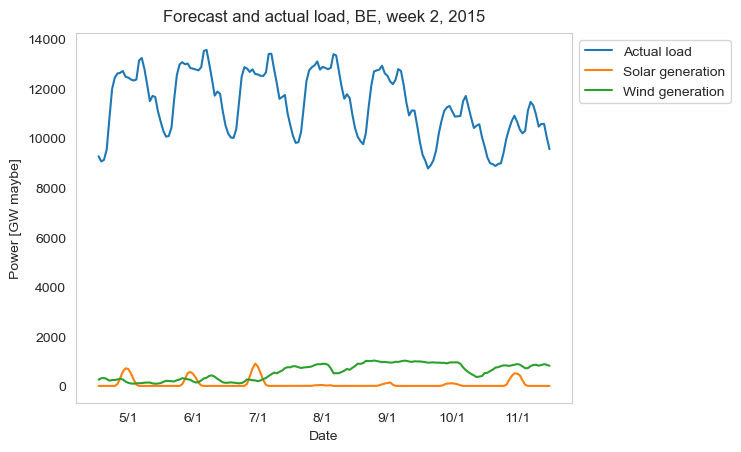

In [8]:
ax = plt.axes()
plt.plot(opsd_15.loc[:,"BE_load_actual_entsoe_transparency"][96:264],label = 'Actual load')
plt.plot(opsd_15.loc[:,"BE_solar_generation_actual"][96:264],label = 'Solar generation')
plt.plot(opsd_15.loc[:,"BE_wind_onshore_generation_actual"][96:264],label = 'Wind generation')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Forecast and actual load, BE, week 2, 2015', y=1.01)
plt.xlabel('Date')
plt.ylabel('Power [GW maybe]')
plt.grid()
ax.set_xticks(['2015-01-05 12:00:00+00','2015-01-06 12:00:00+00', '2015-01-07 12:00:00+00', '2015-01-08 12:00:00+00', '2015-01-09 12:00:00+00', '2015-01-10 12:00:00+00', '2015-01-11 12:00:00+00'])
ax.set_xticklabels(['5/1','6/1','7/1','8/1','9/1','10/1','11/1'])

# HYDRO FOR ALL COUNTRIES FROM ENTSO-E, 2015-2016

Hydro data are found for 2015 and 2016 on ENTSO-E transparency, https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=TABLE&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=16.03.2016+00:00|CET|DAYTIMERANGE&dateTime.endDateTime=16.03.2016+00:00|CET|DAYTIMERANGE&area.values=CTY|10YFR-RTE------C!CTY|10YFR-RTE------C&productionType.values=B11&productionType.values=B12&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)#
Data used is from run-of-river and water reservoir. Data is saved as .csv files and named, e.g. for DK in 2015: "DK_hydro_2015". Time values are in UTC.

All countries has data for every 60 mins except Austria, Hungary, Germany and Luxemburg, which has for every 15 mins. This will be averaged into an hourly value. 

In [9]:
import glob
#Importing file paths with glob

path = '../Hydro production data/'
hydro_file_paths_2015 = glob.glob(path + '2015/'+ '*.csv')
hydro_file_paths_2016 = glob.glob(path + '2016/'+ '*.csv')

#### How the for-loop works
The "split" function must be done in the loop so that only the first part of the time is kept. Then, there should be an if-function that check whether the frequency is 1 hr. If NOT the index needs to be changed to DateTimeIndex and the "resample" function needs to be used. 

Back in the for-loop, the columns 2 and 3 must be concated.
Also in the for-loop, the column header must be changed for all so that the country name is a part of it. 


Since the first file in hydro_15 is AT, which has a frequency of 30 mins, the same stuff has to be done before the for-loop to initialize a dataframe that is correct before concating

## For-loop that reads the data into one big dataframe with DateTimeIndex, freq = 1H

### Initializing - making the AT-Dataframe correct

In [10]:
hydro_2015 = pd.read_csv(hydro_file_paths_2015[0])
hydro_2016 = pd.read_csv(hydro_file_paths_2016[0])

#Removing the last part of the timestamp - will only keep the starting time
hydro_2015['MTU'] = hydro_2015['MTU'].map(lambda x: x.split('-')[0])
hydro_2016['MTU'] = hydro_2016['MTU'].map(lambda x: x.split('-')[0])

#Changing index to DateTimeIndex
hydro_2015.index = pd.to_datetime(hydro_2015['MTU'])
hydro_2016.index = pd.to_datetime(hydro_2016['MTU'])

#Changing NaN and n/e to 0
hydro_2015 = hydro_2015.fillna(0)
hydro_2015 = hydro_2015.replace('n/e',0)
hydro_2016 = hydro_2016.fillna(0)
hydro_2016 = hydro_2016.replace('n/e',0)

#Changing name of columns so they include country code
hydro_2015.columns = ['del','del','AT Run-of-river - Actual [MW]','AT Water Reservoir - Actual [MW]']
hydro_2016.columns = ['del','del','AT Run-of-river - Actual [MW]','AT Water Reservoir - Actual [MW]']

hydro_2015 = hydro_2015.drop(['del'],axis=1)
hydro_2016 = hydro_2016.drop(['del'],axis=1)

# CHanging frequency to 1hr
hydro_2015 = hydro_2015.resample("1H").mean()
hydro_2016 = hydro_2016.resample("1H").mean()

hydro_2016

,AT Run-of-river - Actual [MW],AT Water Reservoir - Actual [MW]
MTU,,
2016-01-01 00:00:00,1192.00,171.75
2016-01-01 01:00:00,1196.50,151.50
2016-01-01 02:00:00,1203.75,173.00
2016-01-01 03:00:00,1214.25,143.50
2016-01-01 04:00:00,1225.25,161.00
...,...,...
2016-12-31 19:00:00,1841.25,258.25
2016-12-31 20:00:00,1806.25,225.50
2016-12-31 21:00:00,1640.50,565.50


### Making for-loop that does it for it all

For-loop that starts from Belgium. 

In [11]:
Country_codes = ['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MD', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SK', 'SL', 'UA', 'XK']
i = 1    #Initializing iteration counter

for filename in range(len(hydro_file_paths_2015)-1):
    print(i,'-',Country_codes[i])
    temporary_hydro_15 = pd.read_csv(hydro_file_paths_2015[i])    #Loading current file 
    temporary_hydro_16 = pd.read_csv(hydro_file_paths_2016[i])    #Loading current file 
    
    #Removing the last part of the timestamp - will only keep the starting time
    temporary_hydro_15['MTU'] = temporary_hydro_15['MTU'].map(lambda x: x.split('-')[0])
    temporary_hydro_16['MTU'] = temporary_hydro_16['MTU'].map(lambda x: x.split('-')[0])
    
    #Changing index to DateTimeIndex
    temporary_hydro_15.index = pd.to_datetime(temporary_hydro_15['MTU'])
    temporary_hydro_16.index = pd.to_datetime(temporary_hydro_16['MTU'])

    #Changing NaN and n/e to 0
    temporary_hydro_15 = temporary_hydro_15.fillna(0)
    temporary_hydro_15 = temporary_hydro_15.replace('n/e',0)
    temporary_hydro_16 = temporary_hydro_16.fillna(0)
    temporary_hydro_16 = temporary_hydro_16.replace('n/e',0)
    
    #Defining name for column
    col1name = Country_codes[i] + ' Run-of-river - Actual [MW]'
    col2name = Country_codes[i] + ' Water Reservoir - Actual [MW]'
    
    temporary_hydro_15.columns = ['del','del',col1name,col2name]
    temporary_hydro_16.columns = ['del','del',col1name,col2name]
    
    temporary_hydro_15 = temporary_hydro_15.drop(['del'],axis=1)
    temporary_hydro_16 = temporary_hydro_16.drop(['del'],axis=1)
    
    # IF STATEMENT FOR COUNTRIES WITH MORE THAN HOURLY RESOLUTION
    if temporary_hydro_15.shape[0] != 8760:

        # Changing frequency to 1hr
        temporary_hydro_15 = temporary_hydro_15.resample("1H").mean()
        temporary_hydro_16 = temporary_hydro_16.resample("1H").mean()
    
    hydro_2015 = pd.concat([hydro_2015,temporary_hydro_15],axis=1,copy=False)
    hydro_2016 = pd.concat([hydro_2016,temporary_hydro_16],axis=1,copy=False)
    i=i+1

1 - BE
2 - BG
3 - CH
4 - CY
5 - CZ
6 - DE
7 - DK
8 - EE
9 - ES
10 - FI
11 - FR
12 - GB
13 - GE
14 - GR
15 - HR
16 - HU
17 - IE
18 - IT
19 - LT
20 - LU
21 - LV
22 - MD
23 - ME
24 - MK
25 - NL
26 - NO
27 - PL
28 - PT
29 - RO
30 - RS
31 - SE
32 - SK
33 - SL
34 - UA
35 - XK


In [12]:
hydro_2015

,AT Run-of-river - Actual [MW],AT Water Reservoir - Actual [MW],BE Run-of-river - Actual [MW],BE Water Reservoir - Actual [MW],BG Run-of-river - Actual [MW],BG Water Reservoir - Actual [MW],CH Run-of-river - Actual [MW],CH Water Reservoir - Actual [MW],CY Run-of-river - Actual [MW],CY Water Reservoir - Actual [MW],CZ Run-of-river - Actual [MW],CZ Water Reservoir - Actual [MW],DE Run-of-river - Actual [MW],DE Water Reservoir - Actual [MW],DK Run-of-river - Actual [MW],DK Water Reservoir - Actual [MW],EE Run-of-river - Actual [MW],EE Water Reservoir - Actual [MW],ES Run-of-river - Actual [MW],ES Water Reservoir - Actual [MW],FI Run-of-river - Actual [MW],FI Water Reservoir - Actual [MW],FR Run-of-river - Actual [MW],FR Water Reservoir - Actual [MW],GB Run-of-river - Actual [MW],GB Water Reservoir - Actual [MW],GE Run-of-river - Actual [MW],GE Water Reservoir - Actual [MW],GR Run-of-river - Actual [MW],GR Water Reservoir - Actual [MW],HR Run-of-river - Actual [MW],HR Water Reservoir - Actual [MW],HU Run-of-river - Actual [MW],HU Water Reservoir - Actual [MW],IE Run-of-river - Actual [MW],IE Water Reservoir - Actual [MW],IT Run-of-river - Actual [MW],IT Water Reservoir - Actual [MW],LT Run-of-river - Actual [MW],LT Water Reservoir - Actual [MW],LU Run-of-river - Actual [MW],LU Water Reservoir - Actual [MW],LV Run-of-river - Actual [MW],LV Water Reservoir - Actual [MW],MD Run-of-river - Actual [MW],MD Water Reservoir - Actual [MW],ME Run-of-river - Actual [MW],ME Water Reservoir - Actual [MW],MK Run-of-river - Actual [MW],MK Water Reservoir - Actual [MW],NL Run-of-river - Actual [MW],NL Water Reservoir - Actual [MW],NO Run-of-river - Actual [MW],NO Water Reservoir - Actual [MW],PL Run-of-river - Actual [MW],PL Water Reservoir - Actual [MW],PT Run-of-river - Actual [MW],PT Water Reservoir - Actual [MW],RO Run-of-river - Actual [MW],RO Water Reservoir - Actual [MW],RS Run-of-river - Actual [MW],RS Water Reservoir - Actual [MW],SE Run-of-river - Actual [MW],SE Water Reservoir - Actual [MW],SK Run-of-river - Actual [MW],SK Water Reservoir - Actual [MW],SL Run-of-river - Actual [MW],SL Water Reservoir - Actual [MW],UA Run-of-river - Actual [MW],UA Water Reservoir - Actual [MW],XK Run-of-river - Actual [MW],XK Water Reservoir - Actual [MW]
MTU,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1489.75,218.00,36,0,0.0,475,0.0,0.0,0.0,0.0,96.0,30.0,1127.25,60.75,0,0,3.0,0,1009.0,1658.0,668.0,0,4229.0,3732.0,0.0,0.0,0,0,0,0,0.0,0.0,14.0,17.0,133.0,0.0,0.0,0.0,0.0,0,16.00,0.00,0,1,0,0,0,0.0,0,0,0.0,0.0,1238.0,10477.0,0.0,0.0,967,705,0.0,0.0,0.0,0.0,0,0.0,277.0,0.0,242,0,0,0,0,0
2015-01-01 01:00:00,1459.75,180.50,36,0,0.0,378,0.0,0.0,0.0,0.0,96.0,30.0,1119.00,20.25,0,0,3.0,0,973.0,1371.0,669.0,0,4007.0,3046.0,0.0,0.0,0,0,0,0,0.0,0.0,14.0,17.0,132.0,0.0,0.0,0.0,0.0,0,15.75,0.00,0,0,0,0,0,0.0,0,0,0.0,0.0,1230.0,10123.0,0.0,0.0,568,474,0.0,0.0,0.0,0.0,0,0.0,278.0,0.0,104,0,0,0,0,0
2015-01-01 02:00:00,1429.75,223.25,36,0,0.0,295,0.0,0.0,0.0,0.0,96.0,30.0,1115.75,6.75,0,0,3.0,0,949.0,779.0,605.0,0,3787.0,1726.0,0.0,0.0,0,0,0,0,0.0,0.0,14.0,17.0,131.5,0.0,0.0,0.0,0.0,0,15.25,0.00,0,0,0,0,0,0.0,0,0,0.0,0.0,1232.0,9897.0,0.0,0.0,392,401,0.0,0.0,0.0,0.0,0,0.0,278.0,0.0,83,0,0,0,0,0
2015-01-01 03:00:00,1447.50,277.75,37,0,0.0,290,0.0,0.0,0.0,0.0,96.0,30.0,1110.75,1.25,0,0,3.0,0,953.0,720.0,594.0,0,3654.0,810.0,0.0,0.0,0,0,0,0,0.0,0.0,14.0,17.0,131.5,0.0,0.0,0.0,0.0,0,15.00,0.00,0,0,0,0,0,0.0,0,0,0.0,0.0,1234.0,9697.0,0.0,0.0,404,168,0.0,0.0,0.0,0.0,0,0.0,278.0,0.0,80,0,0,0,0,0
2015-01-01 04:00:00,1448.25,252.75,37,0,0.0,272,0.0,0.0,0.0,0.0,96.0,30.0,1106.25,1.50,0,0,3.0,0,952.0,743.0,648.0,0,3594.0,1090.0,0.0,0.0,0,0,0,0,0.0,0.0,13.0,16.0,133.5,0.0,0.0,0.0,0.0,0,15.00,0.00,0,0,0,0,0,0.0,0,0,0.0,0.0,1228.0,9784.0,0.0,0.0,410,152,0.0,0.0,0.0,0.0,0,0.0,280.0,0.0,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [13]:
hydro_2016

,AT Run-of-river - Actual [MW],AT Water Reservoir - Actual [MW],BE Run-of-river - Actual [MW],BE Water Reservoir - Actual [MW],BG Run-of-river - Actual [MW],BG Water Reservoir - Actual [MW],CH Run-of-river - Actual [MW],CH Water Reservoir - Actual [MW],CY Run-of-river - Actual [MW],CY Water Reservoir - Actual [MW],CZ Run-of-river - Actual [MW],CZ Water Reservoir - Actual [MW],DE Run-of-river - Actual [MW],DE Water Reservoir - Actual [MW],DK Run-of-river - Actual [MW],DK Water Reservoir - Actual [MW],EE Run-of-river - Actual [MW],EE Water Reservoir - Actual [MW],ES Run-of-river - Actual [MW],ES Water Reservoir - Actual [MW],FI Run-of-river - Actual [MW],FI Water Reservoir - Actual [MW],FR Run-of-river - Actual [MW],FR Water Reservoir - Actual [MW],GB Run-of-river - Actual [MW],GB Water Reservoir - Actual [MW],GE Run-of-river - Actual [MW],GE Water Reservoir - Actual [MW],GR Run-of-river - Actual [MW],GR Water Reservoir - Actual [MW],HR Run-of-river - Actual [MW],HR Water Reservoir - Actual [MW],HU Run-of-river - Actual [MW],HU Water Reservoir - Actual [MW],IE Run-of-river - Actual [MW],IE Water Reservoir - Actual [MW],IT Run-of-river - Actual [MW],IT Water Reservoir - Actual [MW],LT Run-of-river - Actual [MW],LT Water Reservoir - Actual [MW],LU Run-of-river - Actual [MW],LU Water Reservoir - Actual [MW],LV Run-of-river - Actual [MW],LV Water Reservoir - Actual [MW],MD Run-of-river - Actual [MW],MD Water Reservoir - Actual [MW],ME Run-of-river - Actual [MW],ME Water Reservoir - Actual [MW],MK Run-of-river - Actual [MW],MK Water Reservoir - Actual [MW],NL Run-of-river - Actual [MW],NL Water Reservoir - Actual [MW],NO Run-of-river - Actual [MW],NO Water Reservoir - Actual [MW],PL Run-of-river - Actual [MW],PL Water Reservoir - Actual [MW],PT Run-of-river - Actual [MW],PT Water Reservoir - Actual [MW],RO Run-of-river - Actual [MW],RO Water Reservoir - Actual [MW],RS Run-of-river - Actual [MW],RS Water Reservoir - Actual [MW],SE Run-of-river - Actual [MW],SE Water Reservoir - Actual [MW],SK Run-of-river - Actual [MW],SK Water Reservoir - Actual [MW],SL Run-of-river - Actual [MW],SL Water Reservoir - Actual [MW],UA Run-of-river - Actual [MW],UA Water Reservoir - Actual [MW],XK Run-of-river - Actual [MW],XK Water Reservoir - Actual [MW]
MTU,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1192.00,171.75,24,0,0.0,60,32.0,318,0.0,0.0,107.0,32.0,970.50,60.50,0,0,3.0,0,682.0,1840.0,1144.0,0,2562.0,555.0,756.5,0.0,0,0,0,0,0.0,0.0,10.0,14.0,185.5,0.0,1163,81,22.0,0,8.00,0.00,0.0,0,0,0,0,0,0,0,0.0,0.0,1270,14157,112,0,577,74,329.0,706.0,0.0,0.0,0,5102,100.0,0.0,75,0,0,0,0,0
2016-01-01 01:00:00,1196.50,151.50,24,0,0.0,60,32.0,308,0.0,0.0,107.0,32.0,967.75,61.50,0,0,3.0,0,660.0,1343.0,1210.0,0,2514.0,378.0,644.5,0.0,0,0,0,0,0.0,0.0,10.0,14.0,188.0,0.0,1089,20,22.0,0,8.75,0.00,0.0,0,0,0,0,0,0,0,0.0,0.0,1271,13636,112,0,374,104,321.0,595.0,0.0,0.0,0,4981,101.0,0.0,49,0,0,0,0,0
2016-01-01 02:00:00,1203.75,173.00,24,0,0.0,58,31.0,299,0.0,0.0,108.0,31.0,954.50,62.25,0,0,3.0,0,651.0,906.0,1143.0,0,2602.0,200.0,642.5,0.0,0,0,0,0,0.0,0.0,10.0,14.0,186.5,0.0,1010,20,22.0,0,8.75,0.00,0.0,0,0,0,0,0,0,0,0.0,0.0,1268,13147,112,0,371,98,341.0,422.0,0.0,0.0,0,4964,100.0,0.0,45,0,0,0,0,0
2016-01-01 03:00:00,1214.25,143.50,24,0,0.0,58,31.0,295,0.0,0.0,108.0,31.0,949.00,48.75,0,0,3.0,0,626.0,545.0,1153.0,0,2676.0,390.0,712.0,0.0,0,0,0,0,0.0,0.0,10.0,14.0,173.5,0.0,988,20,22.0,0,9.00,0.00,0.0,0,0,0,0,0,0,0,0.0,0.0,1275,13032,112,0,311,69,353.0,419.0,0.0,0.0,0,4957,100.0,0.0,45,0,0,0,0,0
2016-01-01 04:00:00,1225.25,161.00,24,0,0.0,63,31.0,309,0.0,0.0,104.0,42.0,941.50,53.75,0,0,3.0,0,616.0,446.0,1137.0,0,2662.0,238.0,927.0,0.0,0,0,0,0,0.0,0.0,10.0,14.0,174.0,0.0,1001,24,22.0,0,8.75,0.00,0.0,0,0,0,0,0,0,0,0.0,0.0,1274,13474,111,0,237,68,350.0,403.0,0.0,0.0,0,5174,101.0,0.0,45,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# SUMMARY
The solar and wind data for each country from 2015-2020 is saved in the opsd dataframe. 
The hydro data for wach country for 2015-2016 is saved in the hydro_2015 and hydro_2016 dataframe respectively. 

All values are hourly

# COMPARISON WITH ERA-5
Want to compare the actual generation from ENTSO-E with the generation determined using atlite (ERA-5). 

To start, this is done for Austria. 


In [15]:
cutout = atlite.Cutout(
    path="western-europe-2015-03.nc",
    module="era5",
    x=slice(9.418, 17.181),    #Longitude
    y=slice(46.373 , 49.005), #Latitude
    #time=slice("2015-03-01","2015-03-21"),           #March 2015
)

C:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, x, y are ignored, since cutout is already built.
  warn(


In [16]:
cutout.prepare()

<Cutout "western-europe-2015-03">
 x = 9.50 ⟷ 17.00, dx = 0.25
 y = 46.50 ⟷ 49.00, dy = 0.25
 time = 2015-03-01 ⟷ 2015-03-07, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

At cutout with values for entire march:

In [23]:
cutout_03_2015 = atlite.Cutout(
    path="AT-2015-03.nc",
    module="era5",
    x=slice(9.418, 17.181),    #Longitude
    y=slice(46.373 , 49.005), #Latitude
    time="2015-03"              #March 2015 - entire month
)

In [24]:
cutout_03_2015.prepare()

[########################################] | 100% Completed | 889.78 ms


<Cutout "AT-2015-03">
 x = 9.50 ⟷ 17.00, dx = 0.25
 y = 46.50 ⟷ 49.00, dy = 0.25
 time = 2015-03-01 ⟷ 2015-03-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

Seeing what features are available: 

In [50]:
cutout_03_2015.data.runoff

<xarray.DataArray 'runoff' (time: 744, y: 11, x: 31)>
dask.array<open_dataset-bc9c72194dca52c4533da550f4e9257arunoff, shape=(744, 11, 31), dtype=float32, chunksize=(100, 11, 31), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 9.5 9.75 10.0 10.25 10.5 ... 16.0 16.25 16.5 16.75 17.0
  * y        (y) float64 46.5 46.75 47.0 47.25 47.5 ... 48.25 48.5 48.75 49.0
  * time     (time) datetime64[ns] 2015-03-01 ... 2015-03-31T23:00:00
    lon      (x) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    lat      (y) float64 dask.array<chunksize=(11,), meta=np.ndarray>
Attributes:
    units:      m
    long_name:  Runoff
    module:     era5
    feature:    runoff

In [32]:
# DEFINING SHAPE OF AUSTRIA
shpfilename = shpreader.natural_earth(
        resolution="10m",category="cultural",name="admin_0_countries")

reader = shpreader.Reader(shpfilename)
Austria = gpd.GeoSeries(
    {r.attributes["NAME_EN"]:r.geometry for r in reader.records()},
    crs={"init":"epsg:4326"},
).reindex(["Austria"])

C:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


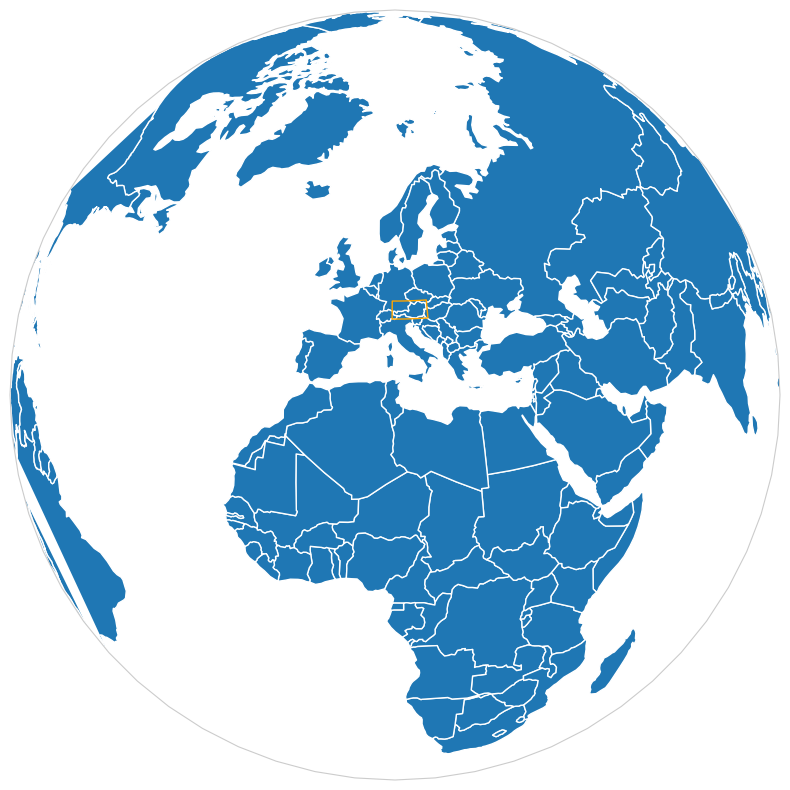

In [38]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

# Creating projection (to orient Earth on the figure)
projection = ccrs.Orthographic(10,35)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8, 8))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
fig.tight_layout()

Plotting the values obtained from ERA5 using atlite. Plotting windspeed at 100 m, direct influx and runoff. 

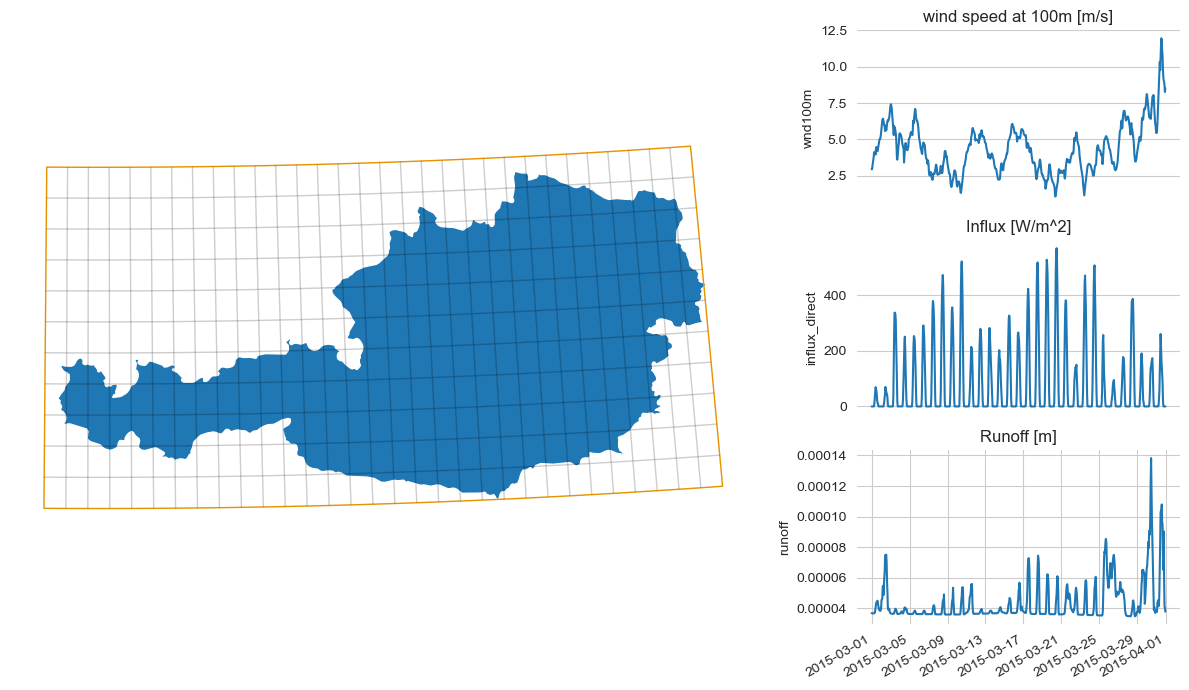

In [54]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
Austria.plot(ax=ax, zorder=1, transform=plate(),aspect="equal")
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
ax.set_frame_on(False)

ax1 = fig.add_subplot(gs[0, 2])
cutout_03_2015.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)
ax1.title.set_text('wind speed at 100m [m/s]')

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout_03_2015.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)
ax2.title.set_text('Influx [W/m^2]')

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout_03_2015.data.runoff.mean(["x", "y"]).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
ax3.title.set_text('Runoff [m]')
fig.tight_layout()

## Land use availability
In order to compare it to actual generation data, a map must be created which shows where in the country it makes sense to have PV installations (and wind). Therefore land use availability is examined so that a solar and wind layout can be made. 

C:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


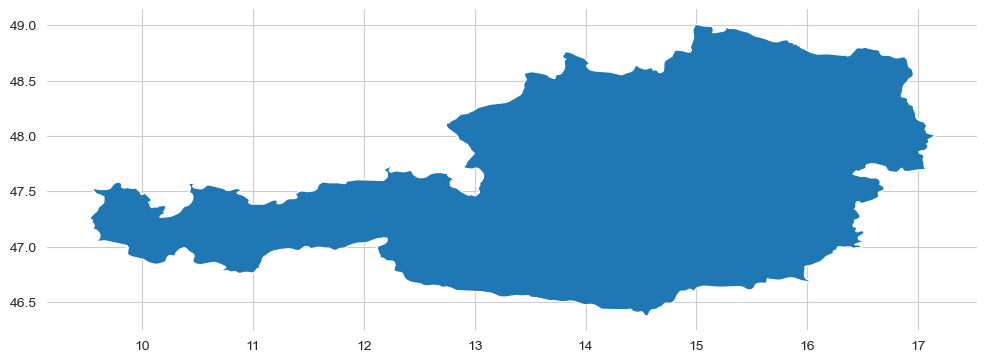

In [98]:
Austria_fig = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Austria"]).plot(figsize=(12, 8),aspect="equal")
Austria_fig.set_frame_on(False)

In [101]:
world = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Austria"])
bounds = world.cascaded_union.buffer(1).bounds

C:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Theag\AppData\Local\Temp\ipykernel_15188\2249379564.py:5: FutureWarning: The 'cascaded_union' attribute is deprecated, use 'unary_union' instead
  bounds = world.cascaded_union.buffer(1).bounds


<Axes: >

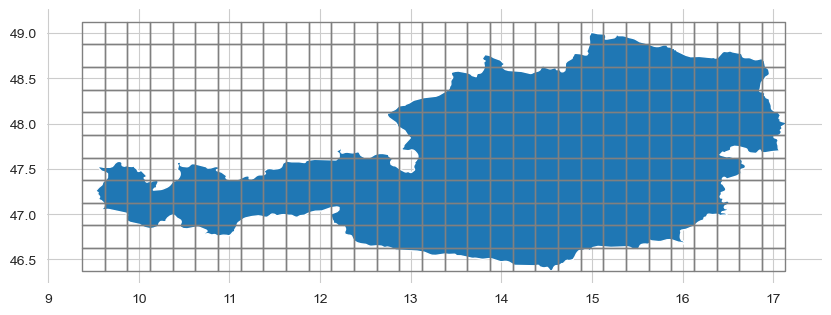

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax,aspect="equal").set_frame_on(False)
cutout_03_2015.grid.plot(ax=ax, edgecolor="grey", color="None",aspect="equal")

In [108]:
CORINE = "corine.tif"
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=range(20))
austria = world.loc[["Austria"]].geometry.to_crs(excluder.crs)
masked, transform = shape_availability(austria, excluder)
eligible_share = masked.sum() * excluder.res**2 / austria.geometry.item().area

0.6935377607683242

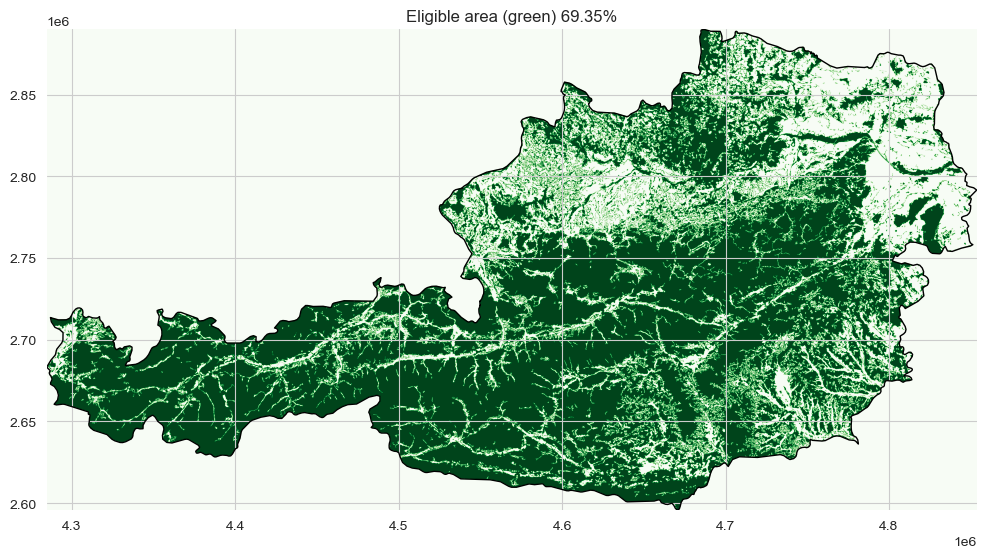

In [111]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = show(masked, transform=transform, cmap="Greens", ax=ax)
austria.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)
ax.set_title(f"Eligible area (green) {eligible_share * 100:2.2f}%");

In [114]:
A_matrix = cutout_03_2015.availabilitymatrix(world,excluder)

Compute availability matrix: 100%|██████████| 1/1 [00:01<00:00,  1.58s/ gridcells]


<Axes: title={'center': 'dim_0 = Austria'}, xlabel='x', ylabel='y'>

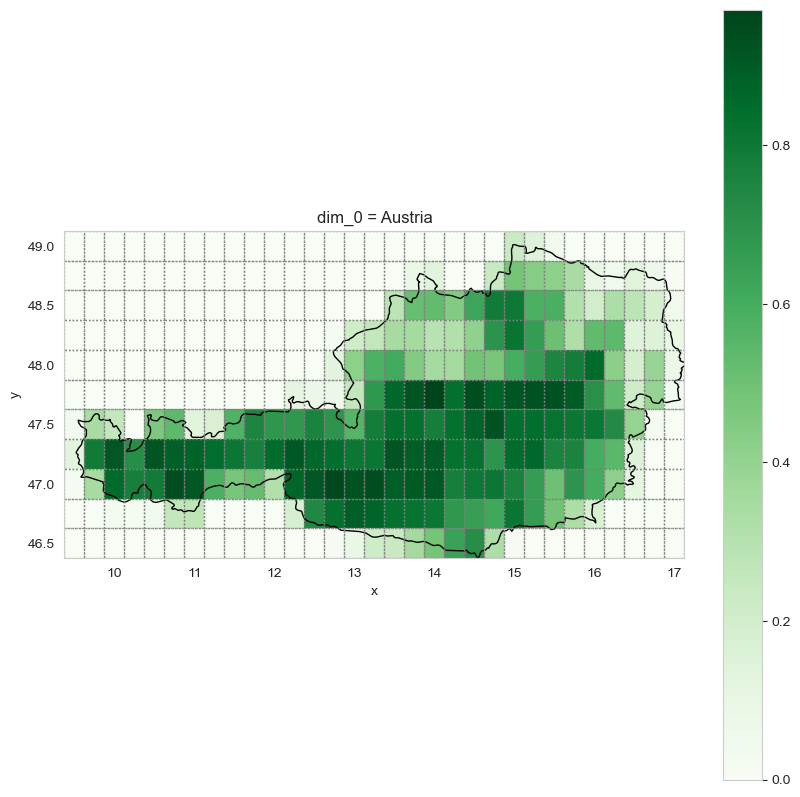

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))
A_matrix.plot(cmap="Greens")
world.loc[["Austria"]].plot(ax=ax, edgecolor="k", color="None")
cutout_03_2015.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

In [127]:
cap_per_sqkm = 1.2    #Setting installed capacity per unit area
area = cutout_03_2015.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A_matrix.stack(spatial=["y", "x"]) * area * cap_per_sqkm

### Predicting wind power production based on weather
Plotting the wind capacity factors based on ERA5 (atlite). Want to use a 5MW turbine as statet in project description. atlite has one 5.5MW onshore windmill, "NREL_ReferenceTurbine_2020ATB_5.5MW". 

**Plotting the wind CF without taking land use availability into account**

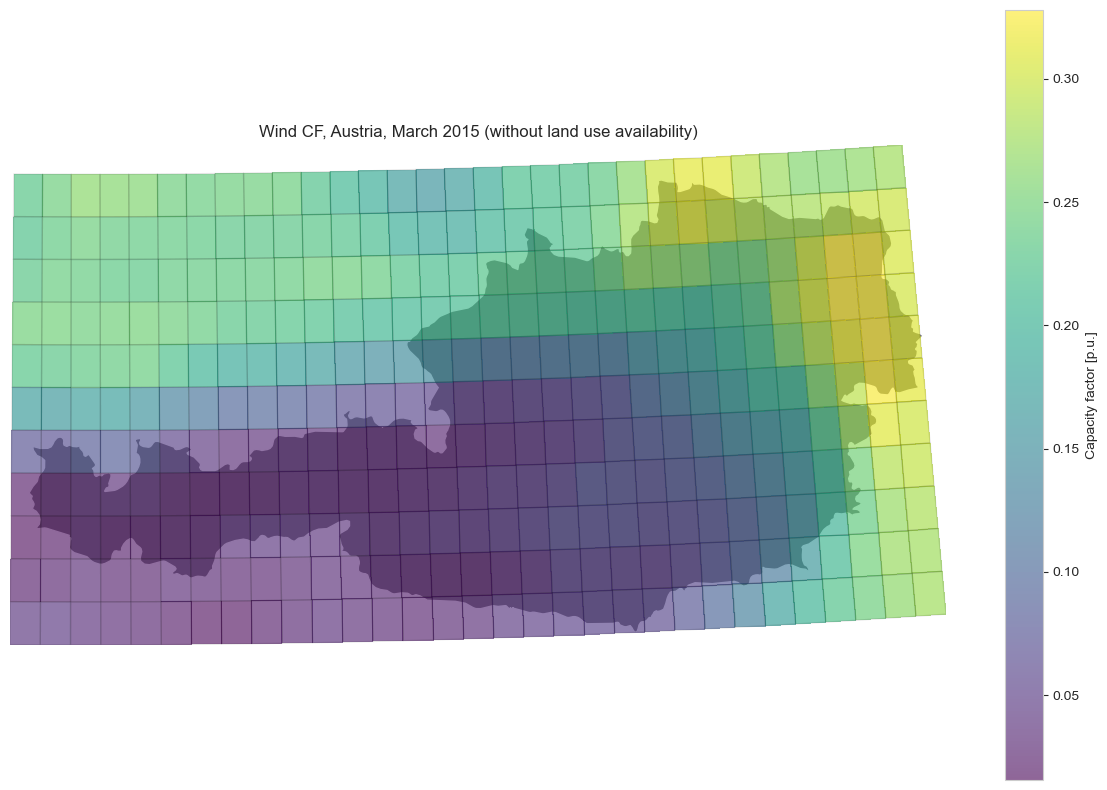

In [130]:
wind_gen = cutout_03_2015.wind(
    turbine='NREL_ReferenceTurbine_2020ATB_5.5MW',smooth=True) #[MWh/MWp]
wind_5_5MW = cutout_03_2015.wind(
    turbine='NREL_ReferenceTurbine_2020ATB_5.5MW',smooth=True, capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(12, 8))
Austria.plot(ax=ax, zorder=1, transform=plate(),color='grey',aspect="equal")
wind_5_5MW.name = "Capacity factor"
wind_5_5MW.plot(ax=ax, transform=plate(), alpha=0.6)
cells.plot(ax=ax, **plot_grid_dict)
ax.set_frame_on(False)
ax.title.set_text('Wind CF, Austria, March 2015 (without land use availability)')
fig.tight_layout();

### Predicting PV production based on weather
Predicting the PV production in march based on the weather (using atlite and ERA5). It is done using optimal tilt as instructed in plan.

In [120]:
pv_gen = cutout_03_2015.pv(panel="CSi", orientation="latitude_optimal",clearsky_model="simple") #[kWh/kWp]
pv_CF = cutout_03_2015.pv(panel="CSi", orientation="latitude_optimal",clearsky_model="simple",capacity_factor=True)

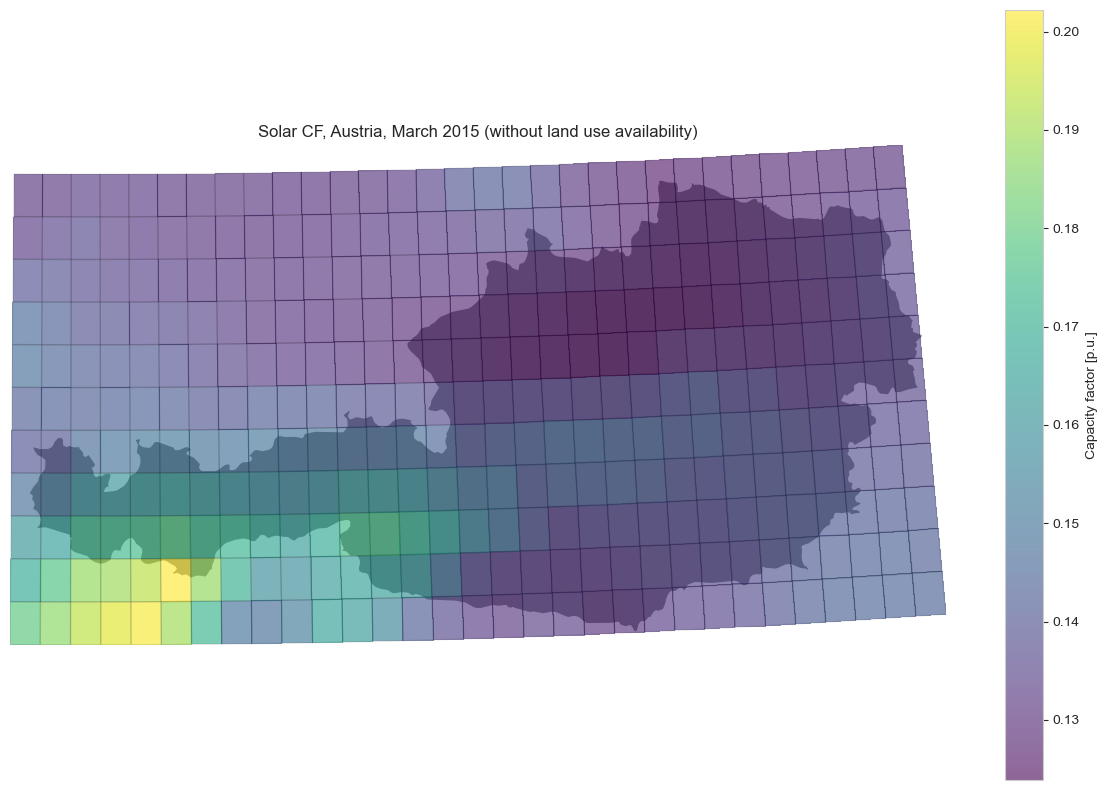

In [131]:
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(12, 8))
Austria.plot(ax=ax, zorder=1, transform=plate(),color='grey',aspect="equal")
pv_CF.name = "Capacity factor"
pv_CF.plot(ax=ax, transform=plate(), alpha=0.6)
cells.plot(ax=ax, **plot_grid_dict)
ax.set_frame_on(False)
ax.title.set_text('Solar CF, Austria, March 2015 (without land use availability)')
fig.tight_layout();

Using the land availability matrix to get a solar production. 
The generation per cell in MW: 

In [128]:
pv = cutout_03_2015.pv(
    matrix=capacity_matrix,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=world.index,
)     #[MW] Generation per country

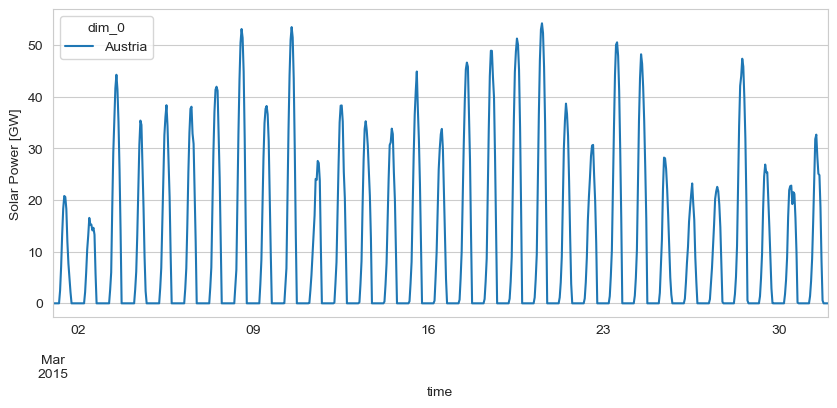

In [133]:
pv.to_pandas().div(1e3).plot(ylabel="Solar Power [GW]", ls="-", figsize=(10, 4));

## Comparing ENTSO-E data with ERA5 predictions
Comparing actual generation from ENTSO-E with the predictions from ERA5 (atlite)

In [142]:
pv.squeeze().to_series()

time
2015-03-01 00:00:00    0.0
2015-03-01 01:00:00    0.0
2015-03-01 02:00:00    0.0
2015-03-01 03:00:00    0.0
2015-03-01 04:00:00    0.0
                      ... 
2015-03-31 19:00:00    0.0
2015-03-31 20:00:00    0.0
2015-03-31 21:00:00    0.0
2015-03-31 22:00:00    0.0
2015-03-31 23:00:00    0.0
Name: specific generation, Length: 744, dtype: float64

In [147]:
opsd_15["AT_solar_generation_actual"]['2015-03-01':'2015-03-31']

utc_timestamp
2015-03-01 00:00:00    0.0
2015-03-01 01:00:00    0.0
2015-03-01 02:00:00    0.0
2015-03-01 03:00:00    0.0
2015-03-01 04:00:00    0.0
                      ... 
2015-03-31 19:00:00    0.0
2015-03-31 20:00:00    0.0
2015-03-31 21:00:00    0.0
2015-03-31 22:00:00    0.0
2015-03-31 23:00:00    0.0
Name: AT_solar_generation_actual, Length: 744, dtype: float64

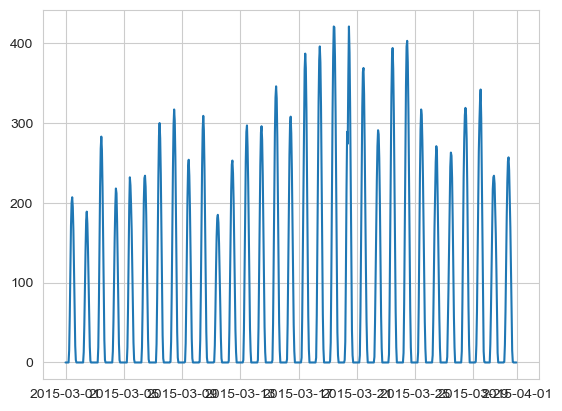

In [148]:

plt.plot(opsd_15["AT_solar_generation_actual"]['2015-03-01':'2015-03-31'])

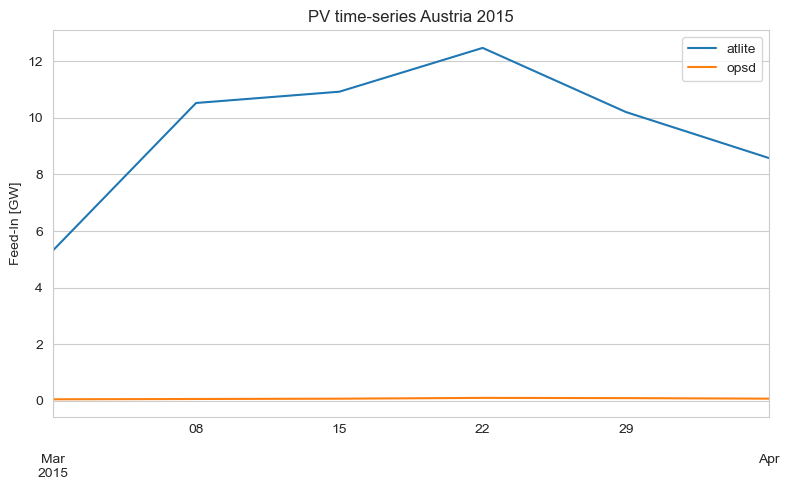

In [152]:
compare = (
    pd.DataFrame(
        dict(atlite=pv.squeeze().to_series(),opsd=opsd_15["AT_solar_generation_actual"]['2015-03-01':'2015-03-31'])
    )
    /1e3
)    #in GW
compare.resample("1W").mean().plot(figsize=(8, 5))
plt.ylabel("Feed-In [GW]")
plt.title("PV time-series Austria 2015")
plt.tight_layout()